 # Обучение сети с двумя параметрами V_gs и V_ds

Будем обучать сеть в пятью входными данными: Vgs, Vds, Width, Length, Temperature

In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [ ]:
# !python -m pip install tensorflow

Загружаем свой датасет


In [3]:
df = pd.read_csv('mosfet_2p.csv')

# df = pd.read_csv('training_data.csv')

In [4]:
df.shape

(49599, 3)

In [5]:
df.describe()

,Vds,Vgs,Id
count,49599.000000,49599.000000,49599.000000
mean,2.500000,2.500000,0.000671
std,1.446274,1.581155,0.000815
min,0.000000,0.000000,-0.000000
25%,1.250000,1.000000,0.000026
50%,2.500000,2.500000,0.000318
75%,3.750000,4.000000,0.001024
max,5.000000,5.000000,0.003453


In [9]:
# df['Vds'].unique() 

## Подготовка данных

Подготовим входные данные и заменим нули

In [10]:
df[df['Id'] != 0.0]['Id'].min()

1.2854814272937135e-14

In [11]:
df[df['Vgs'] != 0.0]['Vgs'].min()

0.5

In [12]:
df[df['Vds'] != 0.0]['Vds'].min()

0.01

In [14]:
REPLACE_ZERO_ID = 1e-15
REPLACE_ZERO_VGS = 1e-3
REPLACE_ZERO_VDS = 1e-3

In [16]:
# Replace zeros
df["Id"].replace({0:REPLACE_ZERO_ID}, inplace=True)
df["Vgs"].replace({0:REPLACE_ZERO_VGS}, inplace=True)
df["Vds"].replace({0:REPLACE_ZERO_VDS}, inplace=True)

# get data

id=df["Id"]
Vgs=df["Vgs"]
Vds=df["Vds"]


y_raw=np.ravel(id)
X_raw=df.iloc[:,0:2]

In [17]:
X_raw

,Vds,Vgs
0,0.001,0.001
1,0.010,0.001
2,0.020,0.001
3,0.030,0.001
4,0.040,0.001
...,...,...
49594,4.960,5.000
49595,4.970,5.000
49596,4.980,5.000
49597,4.990,5.000


In [18]:
#Normalize data before training

X=np.log10(X_raw)
y=-1/np.log10(y_raw)

# X=np.log(X_raw)
#y=np.log10(y_raw)
# y=-1/np.log(y_raw)

In [19]:
X

,Vds,Vgs
0,-3.000000,-3.00000
1,-2.000000,-3.00000
2,-1.698970,-3.00000
3,-1.522879,-3.00000
4,-1.397940,-3.00000
...,...,...
49594,0.695482,0.69897
49595,0.696356,0.69897
49596,0.697229,0.69897
49597,0.698101,0.69897


**Разделение набора данных на обучающий и тестовый наборы**

In [20]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Нормализуем значения $I_d$ так чтобы выходные значения были в пределах 0 и 1

In [21]:
y_train=y_train.reshape(-1,1) #reshape the data before feeding to network
y_test=y_test.reshape(-1,1)

## Построение модели

**Import Tensorflow and Keras**

In [22]:
import tensorflow as tf
from tensorflow import keras

Note: Relu as activation finction may be used for hidden layers but result might not be smooth. For any compact model, it should be continuous so that it is compatible with Newton algorithm which is used in SPICE simulators.

In [25]:
# We'll use Keras to create a Neural network

# 2 - 8 - 4 - 1

model = tf.keras.Sequential()

model.add(keras.layers.Dense(8, activation='tanh', input_shape=(2,)))
model.add(keras.layers.Dense(4, activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 24        
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [26]:
t1 = time.perf_counter()

history_1 = model.fit(X_train, y_train, 
                      epochs=1000, 
                      validation_data=(X_test, y_test),
                      batch_size=128,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
310/310 [==============================] - 3s 4ms/step - loss: 0.0209 - mae: 0.0831 - val_loss: 0.0014 - val_mae: 0.0223
Epoch 2/1000
310/310 [==============================] - 1s 4ms/step - loss: 7.8884e-04 - mae: 0.0166 - val_loss: 6.2394e-04 - val_mae: 0.0160
Epoch 3/1000
310/310 [==============================] - 1s 5ms/step - loss: 6.0276e-04 - mae: 0.0163 - val_loss: 5.9165e-04 - val_mae: 0.0163
Epoch 4/1000
310/310 [==============================] - 1s 5ms/step - loss: 5.7588e-04 - mae: 0.0162 - val_loss: 5.6217e-04 - val_mae: 0.0159
Epoch 5/1000
310/310 [==============================] - 1s 3ms/step - loss: 5.4507e-04 - mae: 0.0159 - val_loss: 5.2586e-04 - val_mae: 0.0156
Epoch 6/1000
310/310 [==============================] - 1s 3ms/step - loss: 5.0392e-04 - mae: 0.0154 - val_loss: 4.7653e-04 - val_mae: 0.0150
Epoch 7/1000
310/310 [==============================] - 1s 3ms/step - loss: 4.4518e-04 - mae: 0.0147 - val_loss: 4.0770e-04 - val_mae: 0.0142
Epoch 8/1000
3

Сохраним веса в виде файла

In [27]:
model.save("model_8_4.h5") # save weights

Загрузим веса из файла (по необходимости)

In [28]:
model.load_weights("model_8_4.h5") # load weights

Создадим сеть с другой архитектурой

In [29]:
# Сreate another Neural network

# 2 - 16 - 8 - 4 - 1

model_16_8_4 = tf.keras.Sequential()

model_16_8_4.add(keras.layers.Dense(16, activation='tanh', input_shape=(2,)))
model_16_8_4.add(keras.layers.Dense(8, activation='tanh'))
model_16_8_4.add(keras.layers.Dense(4,activation='tanh'))
model_16_8_4.add(keras.layers.Dense(1, activation='sigmoid'))

model_16_8_4.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_16_8_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                48        
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [30]:
t1 = time.perf_counter()

history_2 = model_16_8_4.fit(X_train, y_train, 
                      epochs=2000, 
                      validation_data=(X_test, y_test),
                      batch_size=64,
                      shuffle=True,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/2000
620/620 [==============================] - 2s 2ms/step - loss: 0.0076 - mae: 0.0523 - val_loss: 0.0010 - val_mae: 0.0230
Epoch 2/2000
620/620 [==============================] - 1s 2ms/step - loss: 6.5153e-04 - mae: 0.0174 - val_loss: 3.2419e-04 - val_mae: 0.0122
Epoch 3/2000
620/620 [==============================] - 1s 2ms/step - loss: 1.9319e-04 - mae: 0.0101 - val_loss: 1.2163e-04 - val_mae: 0.0081
Epoch 4/2000
620/620 [==============================] - 1s 2ms/step - loss: 6.7851e-05 - mae: 0.0060 - val_loss: 3.8992e-05 - val_mae: 0.0042
Epoch 5/2000
620/620 [==============================] - 1s 2ms/step - loss: 1.8568e-05 - mae: 0.0029 - val_loss: 1.3167e-05 - val_mae: 0.0021
Epoch 6/2000
620/620 [==============================] - 1s 2ms/step - loss: 9.4515e-06 - mae: 0.0018 - val_loss: 8.6534e-06 - val_mae: 0.0017
Epoch 7/2000
620/620 [==============================] - 1s 2ms/step - loss: 8.1722e-06 - mae: 0.0017 - val_loss: 8.6166e-06 - val_mae: 0.0017
Epoch 8/2000
6

In [31]:
model_16_8_4.save("model_16_8_4.h5") # save weights

In [32]:
model_16_8_4.load_weights("model_16_8_4.h5") # load weights

**Построим графики loss моделей**

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

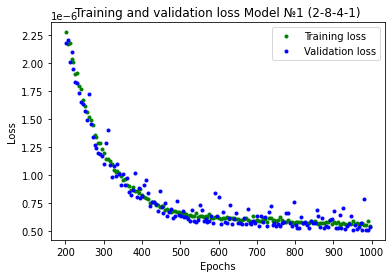

In [34]:
# Exclude the first few epochs so the graph is easier to read
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
SKIP = 200
# SKIP = 0
plt.plot(epochs[SKIP::5], loss[SKIP::5], 'g.', label='Training loss')
plt.plot(epochs[SKIP::5], val_loss[SKIP::5], 'b.', label='Validation loss')
plt.title('Training and validation loss Model №1 (2-8-4-1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

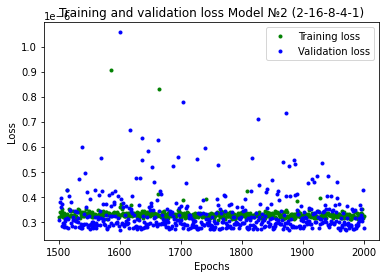

In [40]:
# Exclude the first few epochs so the graph is easier to read
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)
SKIP = -500
# SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss Model №2 (2-16-8-4-1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Тестирование обученной сети

Применим новые данные, на которых сеть не обучалась. 

При этом не забудем про подготовку входных и выходных параметров. 

In [140]:
df1 = pd.read_csv('mosfet_2p_val_1.csv')
_df1 = df1['Vgs'].unique()
_df1

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [141]:
def process_data(df):
  # Replace zeros
  df["Id"].replace({0:REPLACE_ZERO_ID}, inplace=True)
  df["Vgs"].replace({0:REPLACE_ZERO_VGS}, inplace=True)
  df["Vds"].replace({0:REPLACE_ZERO_VDS}, inplace=True)

  # get data

  id=df["Id"]
  Vgs=df["Vgs"]
  Vds=df["Vds"]

  ynew=np.ravel(id)
  xnew=df.iloc[:,0:2]

  #Normalize validation data
  xval=np.log10(xnew)
  #xval=xnew/5
  yval=-1/np.log10(ynew)
  yval=yval.reshape(-1,1)

  return xval, yval, df

In [142]:
xval, yval, df_1 = process_data(df1[df1['Vgs'] == _df1[3]])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


**Plot actual vs. predicted result. Make sure that predicted drain current is de-normalized before plotting.**

*De-normalization required because before feeding to network (training phase), we have converted drain current within 0 to 1 range  so that Sigmoid function can operate. So, predicted current value will be within same range. It should be converted back to it's original form (De-normalization)*

In [143]:
def show_plot(xval, yval, df):
  # Predict the new dataset
  y_pred = model.predict(xval)
  y_pred_16_8_4 = model_16_8_4.predict(xval)

  #plot the result
  vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
  vg=np.ravel(vg1)
  vg=vg.reshape(-1,1)
  # print(vg)
  plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')

  plt.plot(vg, 10**(-1/y_pred), 'b', label='Predicted №1')
  plt.plot(vg, 10**(-1/y_pred_16_8_4), 'g--', label='Predicted №2')

  # plt.yscale("log")
  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()

Вспомним что область обучения лежала в пределах 0 до 5 для напржений

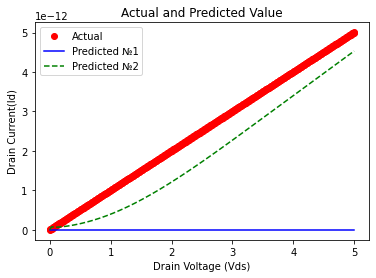

In [144]:
show_plot(xval, yval, df_1)

На малых значения V_gs работает не очень хорошо

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


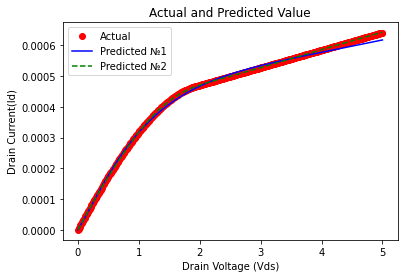

In [145]:
xval, yval, df_1 = process_data(df1[df1['Vgs'] == _df1[int(len(_df1)/2)]])
show_plot(xval, yval, df_1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


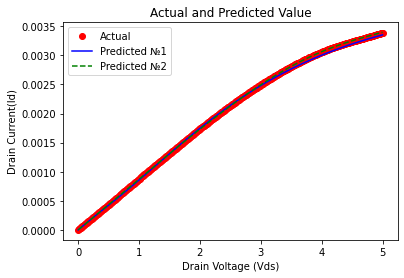

In [146]:
xval, yval, df_1 = process_data(df1[df1['Vgs'] == _df1[-1]])
show_plot(xval, yval, df_1)

Рассмотрим как предсказывает значения вне области обучения для остальных параметров

In [147]:
df1 = pd.read_csv('mosfet_2p_val_2.csv')
_df1 = df1['Vgs'].unique()
_df1

array([5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2,
       6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


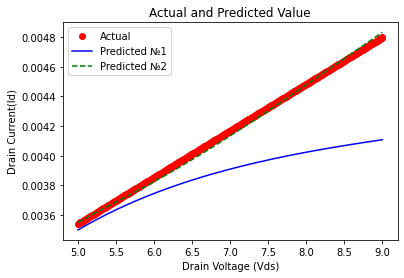

In [148]:
xval, yval, df_1 = process_data(df1[df1['Vgs'] == _df1[1]])
show_plot(xval, yval, df_1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


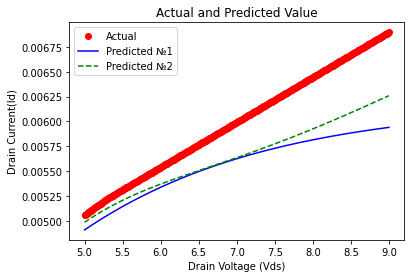

In [149]:
xval, yval, df_1 = process_data(df1[df1['Vgs'] == _df1[int(len(_df1)/2)]])
show_plot(xval, yval, df_1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


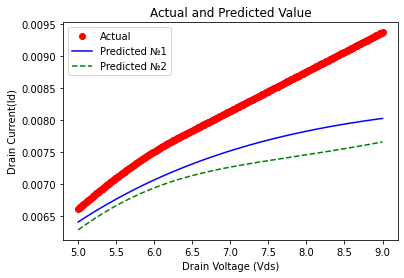

In [150]:
xval, yval, df_1 = process_data(df1[df1['Vgs'] == _df1[-1]])
show_plot(xval, yval, df_1)

Посчитаем MSE для валиадционных данных внутри области обчения

In [151]:
df_val = pd.read_csv('mosfet_2p_val_1.csv')

In [154]:
xval, yval, df_val = process_data(df_val)
y_pred = model.predict(xval)

y_pred_16_8_4 = model_16_8_4.predict(xval)

In [155]:
loss = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred))
l = keras.losses.MSE(yval, y_pred)
print(np.max(loss), np.max(l))
loss = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
print(loss)

2.8710074e-09 0.0014334399
tf.Tensor(1.5008544e-10, shape=(), dtype=float32)


In [156]:
loss = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred_16_8_4))
l = keras.losses.MSE(yval, y_pred_16_8_4)
print(np.max(loss), np.max(l))
loss = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
print(loss)

3.0119476e-10 0.007899117
tf.Tensor(7.5829065e-12, shape=(), dtype=float32)


Посчитаем MSE на данных, которые находятся вне области обучения



In [157]:
df_val_out = pd.read_csv('mosfet_2p_val_2.csv')
xval, yval, df_val = process_data(df_val_out)

y_pred = model.predict(xval)
y_pred_16_8_4 = model_16_8_4.predict(xval)

loss = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred))
l = keras.losses.MSE(yval, y_pred)
print(np.max(loss), np.max(l))
loss = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
print(loss)

1.8123842e-06 0.00025105177
tf.Tensor(2.755423e-07, shape=(), dtype=float32)


In [158]:
loss = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred_16_8_4))
l = keras.losses.MSE(yval, y_pred_16_8_4)
print(np.max(loss), np.max(l))
loss = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
print(loss)

2.9374833e-06 0.00041768202
tf.Tensor(2.7597025e-07, shape=(), dtype=float32)


*The code presented here is a part of our model development framework. Hope, it will encourage others to develop MOSFET models based upon Neural network.*